In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np

from scipy.signal import convolve2d
from imageio import imread

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')


from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

C:\Users\roger\AppData\Local\Temp\ipykernel_22308\1577475357.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


### Import the data

In [7]:
data=np.loadtxt(open('F:\A deep understanding of Deep Learning (with python)\CNNs\mnist_train_small.csv','rb'),delimiter=';')

labels=data[:,0]
data=data[:,1:]

dataNorm=data/np.max(data)

dataNorm=dataNorm.reshape(dataNorm.shape[0],1,28,28)



In [8]:
dataNorm.shape

(20001, 1, 28, 28)

## Create train/test groups using DataLoader

In [21]:
dataT=torch.tensor(dataNorm).float()
labelsT=torch.tensor(labels).long()

train_data, test_data, train_labels, test_labels = train_test_split(
        dataT, labelsT, train_size=.20)


train_data=TensorDataset(train_data,train_labels)
test_data=TensorDataset(test_data,test_labels)

batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [22]:
train_loader.dataset.tensors[0].shape

torch.Size([4000, 1, 28, 28])

## Create the DL Model

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np  # numpy দরকার shape হিসাবের জন্য

# Define the network
def createTheMINSTNet(printtoggle=False):
    class mnistNet(nn.Module):
        def __init__(self, printtoggle):
            super().__init__()
            
            # ১ম convolutional layer: 1 input channel (gray), 10 output filters, 5x5 kernel
            self.conv1 = nn.Conv2d(1, 10, kernel_size=5, stride=1, padding=1)
            
            # ২য় convolutional layer: 10 input channels, 20 output filters
            self.conv2 = nn.Conv2d(10, 20, kernel_size=5, stride=1, padding=1)
            
            # Input image size MNIST: 28x28
            # Conv1 with padding=1, stride=1: output size = 26x26 → MaxPool2d(kernel=2) → 13x13
            # Conv2 with padding=1, stride=1: output size = 11x11 → MaxPool2d(kernel=2) → 5x5
            # Final output shape: [batch, 20, 5, 5] → flatten → 20*5*5 = 500
            expectSize = 20 * 5 * 5

            # Fully connected layers
            self.fc1 = nn.Linear(expectSize, 50)
            self.out = nn.Linear(50, 10)  # 10 classes for digits 0–9

            self.print = printtoggle

        def forward(self, x):
            if self.print: print(f'Input: {x.shape}')

            x = F.relu(F.max_pool2d(self.conv1(x), 2))
            if self.print: print(f'Layer conv1/pool1: {x.shape}')

            x = F.relu(F.max_pool2d(self.conv2(x), 2))
            if self.print: print(f'Layer conv2/pool2: {x.shape}')

            # Flattening the tensor for fully connected layer
            x = x.view(x.size(0), -1)  # batch size ঠিক রেখে বাকিটা এক সারিতে
            if self.print: print(f'Vectorized: {x.shape}')

            x = F.relu(self.fc1(x))
            if self.print: print(f'Layer fc1: {x.shape}')

            x = self.out(x)
            if self.print: print(f'Layer out: {x.shape}')

            return x

    # Network তৈরি
    net = mnistNet(printtoggle)

    # Loss function এবং optimizer define
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossfun, optimizer


### Test the function with one batch

In [24]:
# মডেল, লস ফাংশন এবং অপটিমাইজার তৈরি
net, lossfun, optimizer = createTheMINSTNet(True)

# ট্রেন লোডার থেকে একটি ব্যাচ নেয়া (X = ইনপুট ইমেজ, y = সঠিক লেবেল)
X, y = next(iter(train_loader))

# মডেলে ডেটা দিয়ে প্রেডিকশন (yHat)
yHat = net(X)

# প্রিন্ট আউটপুটের শেইপ
print(' ')
print('yHat (prediction) shape:', yHat.shape)
print('y (true label) shape   :', y.shape)

# লস গণনা
loss = lossfun(yHat, y)
print(' ')
print('Loss:')
print(loss)


Input: torch.Size([32, 1, 28, 28])
Layer conv1/pool1: torch.Size([32, 10, 13, 13])
Layer conv2/pool2: torch.Size([32, 20, 5, 5])
Vectorized: torch.Size([32, 500])
Layer fc1: torch.Size([32, 50])
Layer out: torch.Size([32, 10])
 
yHat (prediction) shape: torch.Size([32, 10])
y (true label) shape   : torch.Size([32])
 
Loss:
tensor(2.3271, grad_fn=<NllLossBackward0>)


In [25]:
summary(net,(1,28,28))

Input: torch.Size([2, 1, 28, 28])
Layer conv1/pool1: torch.Size([2, 10, 13, 13])
Layer conv2/pool2: torch.Size([2, 20, 5, 5])
Vectorized: torch.Size([2, 500])
Layer fc1: torch.Size([2, 50])
Layer out: torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             260
            Conv2d-2           [-1, 20, 11, 11]           5,020
            Linear-3                   [-1, 50]          25,050
            Linear-4                   [-1, 10]             510
Total params: 30,840
Trainable params: 30,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.12
Estimated Total Size (MB): 0.19
----------------------------------------------------------------


### Create a function that trains the model

In [26]:
def function2trainTheModel():
    numepochs = 10

    net, lossfun, optimizer = createTheMINSTNet()

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):
        batchLoss = []
        batchAcc = []
        net.train()

        for X, y in train_loader:
            # Forward pass
            yHat = net(X)
            loss = lossfun(yHat, y)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Record loss and accuracy
            batchLoss.append(loss.item())

            # 🔍 Fixing predictions for classification (multiclass)
            predictions = torch.argmax(yHat, axis=1)
            acc = 100 * torch.mean((predictions == y).float())
            batchAcc.append(acc.item())

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        # Evaluation on test set
        net.eval()
        X, y = next(iter(test_loader))
        with torch.no_grad():
            yHat = net(X)
        testPred = torch.argmax(yHat, axis=1)
        testAcc.append(100 * torch.mean((testPred == y).float()))

    # ✅ Return statement moved OUTSIDE the loop
    return trainAcc, testAcc, losses, net


### Run the model and show the results!

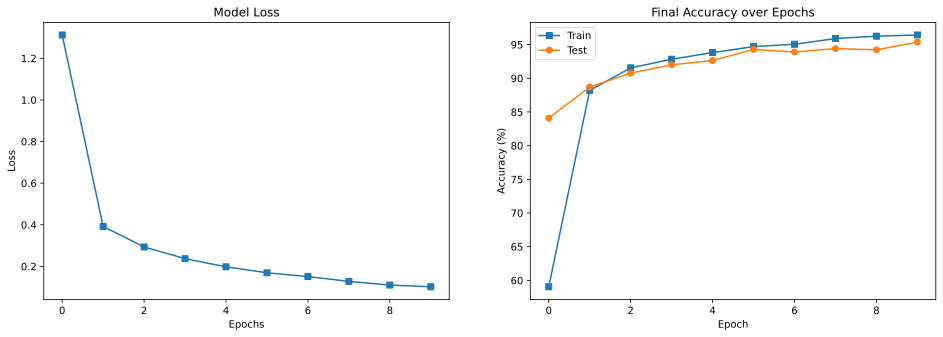

In [27]:
import matplotlib.pyplot as plt
trainAcc, testAcc, losses, net = function2trainTheModel()

# Figure তৈরি করা হয়েছে ১টি row এবং ২টি column সহ subplot নিয়ে
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

# ------------------ Plot 1: Loss ------------------
ax[0].plot(losses, 's-')  # 's-' মানে square মার্কার সহ লাইন
ax[0].set_xlabel('Epochs')  # x-axis label
ax[0].set_ylabel('Loss')    # y-axis label
ax[0].set_title('Model Loss')  # শিরোনাম

# ------------------ Plot 2: Accuracy ------------------
ax[1].plot(trainAcc, 's-', label='Train')  # train accuracy
ax[1].plot(testAcc, 'o-', label='Test')   # test accuracy
ax[1].set_title('Final Accuracy over Epochs')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy (%)')
ax[1].legend()  # লেজেন্ড দেখাবে

# চিত্র দেখানো হবে
plt.show()
